In [1]:
import ROOT, rat
import os, sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
sys.path.append('/home/jp/projects/python_tools')
import jp_mpl as jplot
import rat
from itertools import cycle
plt.rcParams['image.cmap'] = 'YlOrRd'
from scipy.stats import truncnorm

TClass::TClass:0: RuntimeWarning: no dictionary for class omtext is available


In [2]:
gaus = lambda x, normalization, mean, sigma: normalization * np.exp(-0.5 * (x - mean)**2 / sigma**2)
two_gaus = lambda x, n1, m1, s1, n2, m2, s2: gaus(x, n1, m1, s1) + gaus(x, n2, m2, s2)
from scipy import optimize

def getNorm(v):
    return v/np.sqrt(np.sum(v**2))
def renormN(n, axis=0):
    n+= 1E-9

    integral = np.sum(n,axis=axis)
    if axis==0:
        return n/integral
    else:
        return (n.T/integral).T

###  Start here if you have already loaded/selected the tracks

In [3]:
import pickle
data = pickle.load(open('/home/jp/projects/snoplus/rundir/greydisc_validation/onepmt_gdisc_model/condensed_337nm_std.pckl'))


In [4]:
# For all the stored photons, I know who reflected them
# Can I use my ellipsoid formula to find out?

def pmtContactTime( x0, y0, z0, u, v, w, test = False):
    # x0, y0, z0 are the starting point
    # u, v, w are the velocity components
    # ae, ce are ellipsoid characteristics
    ae = 203.7/2.
    ce = 150.3/2.
    a = w**2 / ce**2 + (u**2+v**2)/ae**2
    b = 2.*((u*x0+v*y0)/ae**2 + w*z0/ce**2)
    c = (x0**2 + y0**2)/ae**2 + z0**2/ce**2 -1
    
    contact_time = 0.
    
    inner_sqrt = b**2 -4*a*c
    if test:
        print '\n b',b, b**2
        print 'Num', (u*x0)+(v*y0)
        print 'Num2', w*z0
        print 'a,c', a, c
        print '4ac', 4*a*c
        print inner_sqrt
    if inner_sqrt <= 0:
        return 0.
    
    sol1 = (-b+np.sqrt(inner_sqrt))/(2*a)
    sol2 = (-b-np.sqrt(inner_sqrt))/(2*a)
    
    
    if sol1 < 0 and sol2 < 0:
        mysol = 0.
    else:    
        if sol1 > 0 and sol2 < 0:
            mysol= sol1
        if sol2 > 0 and sol1 < 0:
            mysol= sol2
        if sol1 > 0 and sol2 > 0:
            mysol= np.min([sol1, sol2])

        if pmtContactDepth(z0, w, mysol) < 26.:
            mysol=0.        
        
  
        
    return mysol

def pmtContactDepth(z0, w, t):
    return z0 + t*w

In [5]:
data.keys()

['theta_f',
 'y',
 'phi_f',
 'theta_i',
 'phi_i',
 'r',
 'phidiff',
 'xr',
 'x',
 'nsteps',
 'momentum']

In [6]:
# The momentum is not a unit vector. Don't know why. Renormalizing it
momentum_norm = np.linalg.norm(data['momentum'],axis=1)
momentum_norm = momentum_norm.reshape(momentum_norm.size, 1)
data['momentum'] /= momentum_norm

In [7]:
# Finding almost straight photons
straight = data['momentum'][:,2] < -0.95
print np.sum(straight)
outer_rim = data['r'] > 120.
inner_rim = data['r'] < 70.
print np.sum(outer_rim), np.sum(inner_rim)
#tbool = straight*outer_rim
pmtbool = straight*inner_rim
print np.sum(tbool)

print '\n These are PMT hits'
print np.where(pmtbool == True)[0]

print '\n These are CONCENTRATOR hits'
tbool = straight*outer_rim
print np.where(tbool == True)[0]


153
1054 1740


NameError: name 'tbool' is not defined

In [8]:
#ievent = 240

print 'Raw information'
print data['x'][ievent], data['y'][ievent]
print data['momentum'][ievent], '\n'

print 'Radius', np.sqrt(data['x'][ievent]**2+data['y'][ievent]**2)
pos=[-88.8585, -28.3873, 130.4]#[38.5626, 58.9624, 130.4]
#[36.7448, 56.4996, 130.4]
print 'Radius2', np.sqrt(pos[0]**2 + pos[1]**2)

# The z0 is always equal to 13.18 - see diagram
x0 = pos[0]#-14.1106#data['x'][ievent]
y0 = pos[1]#35.5637#data['y'][ievent]
#x0 = data['x'][ievent]
#y0 = data['y'][ievent]
z0 = 130.4

u = data['momentum'][ievent,0]
v = data['momentum'][ievent,1]
w = data['momentum'][ievent,2]

print 'Position', x0, y0, z0
print 'Momentum', u, v, w

t = pmtContactTime(x0,y0,z0, u,v,w, True)
z = pmtContactDepth(z0, w, t)
print x0 + t*u
print y0 + t*v
print '\n',t, z

Raw information


NameError: name 'ievent' is not defined

In [9]:
print x0*u + y0*v, z0*w
print -0.0944065*38.5626+ -0.218012*58.9624

NameError: name 'x0' is not defined

In [10]:
my_times = np.zeros_like(data['r'])
my_z     = np.zeros_like(my_times)
for ievent in range(len(data['r'])):
    x0 = data['x'][ievent]
    y0 = data['y'][ievent]
    z0 = 130.4

    u = data['momentum'][ievent,0]
    v = data['momentum'][ievent,1]
    w = data['momentum'][ievent,2]
    t = pmtContactTime(x0,y0,z0, u,v,w)
    z = pmtContactDepth(z0, w, t)
    my_times[ievent] = t
    my_z[ievent] = z

In [11]:
my_z.min()

27.910622262279304

In [12]:
pmt_hits = (my_z < 100)
conc_hits = (my_z > 100)

print 'PMT hits', np.sum(pmt_hits)
print 'Concentrator hits', np.sum(conc_hits)


PMT hits 741
Concentrator hits 5139


In [13]:
# Change the theta to do it as a function of cos(theta) - it might show up more interesting correlations
gdr = 138.
def plotReflections(data, sel):
    fig = plt.figure(figsize=(16,14))

    ### First figure - incoming vs diff
    ax1 = fig.add_subplot(221)

    x1 = np.linspace(0, np.pi/2., 41)
    x2 = np.linspace(-np.pi/2, np.pi/2., 51)
    n, x1, x2 = np.histogram2d(data['theta_i'][sel], 
                               data['theta_f'][sel] - data['theta_i'][sel], 
                               [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(np.rad2deg(x1),
               np.rad2deg(x2),
               n.T)
    plt.xlabel('Incoming theta (deg)')
    plt.ylabel('theta_f - theta_i (deg)')
    plt.colorbar()
    plt.title('Outgoing theta - incoming')
    #plt.yticks(np.arange(-90, 90, 5.0))

    
    
    ### Second figure - function of radius
    ax2 = fig.add_subplot(222)
    x1 = np.linspace(0, gdr, 41)
    x2 = np.linspace(-np.pi/2, np.pi/2., 51)
    n, x1, x2 = np.histogram2d(data['r'][sel], 
                               data['theta_f'][sel] - data['theta_i'][sel], 
                               [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(x1,
               np.rad2deg(x2),
               n.T)
    plt.xlabel('Radius (mm)')
    plt.ylabel('theta_f - theta_i (deg)')
    plt.colorbar()
    plt.title('Theta difference vs radius')
    
    
    ### Third figure - cos(theta) incoming vs outgoing
    ax3 = fig.add_subplot(223)
    x1 = np.linspace(0, 1., 41)
    x2 = np.linspace(-1, 1., 51)
    n, x1, x2 = np.histogram2d(np.cos(data['theta_i'][sel]), 
                               np.cos(data['theta_f'][sel])-\
                               np.cos(data['theta_i'][sel]), 
                               [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(x1,
               x2,
               n.T)
    plt.xlabel('cos(theta_i)')
    plt.ylabel('cos(theta_f) - cos(theta_i)')
    plt.colorbar()
    plt.title('Outgoing theta vs radius')  
    
    # Fourth figure - function of contact position
    ax4 = fig.add_subplot(224)
    iev  = 500
    prob = iev*1./len(sel)
    randsel = sel*(np.random.rand(len(sel)) < prob)
    plt.quiver(data['x'][randsel], 
               data['y'][randsel],
               np.cos(data['theta_f'][randsel]), 
               np.sin(data['phi_f'][randsel]))
    plt.xlabel('y (mm)')
    plt.ylabel('z (mm)')

    plt.title('Outgoing theta vs radius') 
    
    
    

    # New figure - everything for phi
    fig2 = plt.figure(figsize=(16,14))

    
    ### Figure
    axb = fig2.add_subplot(221)

    x1 = np.linspace(-np.pi, np.pi, 41)
    x2 = np.linspace(0, np.pi*2, 51)
    n, x1, x2 = np.histogram2d(data['phi_i'][sel], 
                               data['phidiff'][sel], [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(np.rad2deg(x1),
               np.rad2deg(x2),
               n.T)
    plt.xlabel('Incoming phi (deg)')
    plt.ylabel('phi_f - phi_i (deg)')
    plt.colorbar()
    plt.title('Outgoing phi - incoming')

    
    ## Phi change vs radius
    axb2 = fig2.add_subplot(222)
    x1 = np.linspace(0, 138., 41)
    x2 = np.linspace(0, np.pi*2, 51)
    n, x1, x2 = np.histogram2d(data['r'][sel], 
                               data['phidiff'][sel], 
                               [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(x1,
               np.rad2deg(x2),
               n.T)
    plt.xlabel('Radius (mm)')
    plt.ylabel('phi_f - phi_i (deg)')
    plt.colorbar()
    plt.title('Phi difference vs radius')
    
    # Phi change vs incoming theta
    axb3 = fig2.add_subplot(223)
    x1 = np.linspace(0, np.pi/2., 41)
    x2 = np.linspace(0, np.pi*2, 51)
    n, x1, x2 = np.histogram2d(data['theta_i'][sel], 
                               data['phidiff'][sel], 
                               [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(np.rad2deg(x1),
               np.rad2deg(x2),
               n.T)
    plt.xlabel('Incoming theta (deg)')
    plt.ylabel('phi_f - phi_i (deg)')
    plt.colorbar()
    plt.title('Phi difference vs incoming theta')    
    
    # Outpgoing phi as function of radius
    axb4 = fig2.add_subplot(224)

    
    # outgoing phi as a function of radius?
    plt.title('Change in phi vs radius')
    iev  = 500
    prob = iev*1./len(sel)
    randsel = sel*(np.random.rand(len(sel)) < prob)
    plt.quiver(data['x'][randsel], 
               data['y'][randsel],
               np.cos(data['phi_f'][randsel] - data['phi_i'][randsel]), 
               np.sin(data['phi_f'][randsel] - data['phi_i'][randsel]))
    plt.xlabel('y (mm)')
    plt.ylabel('z (mm)')

Selecting all the events


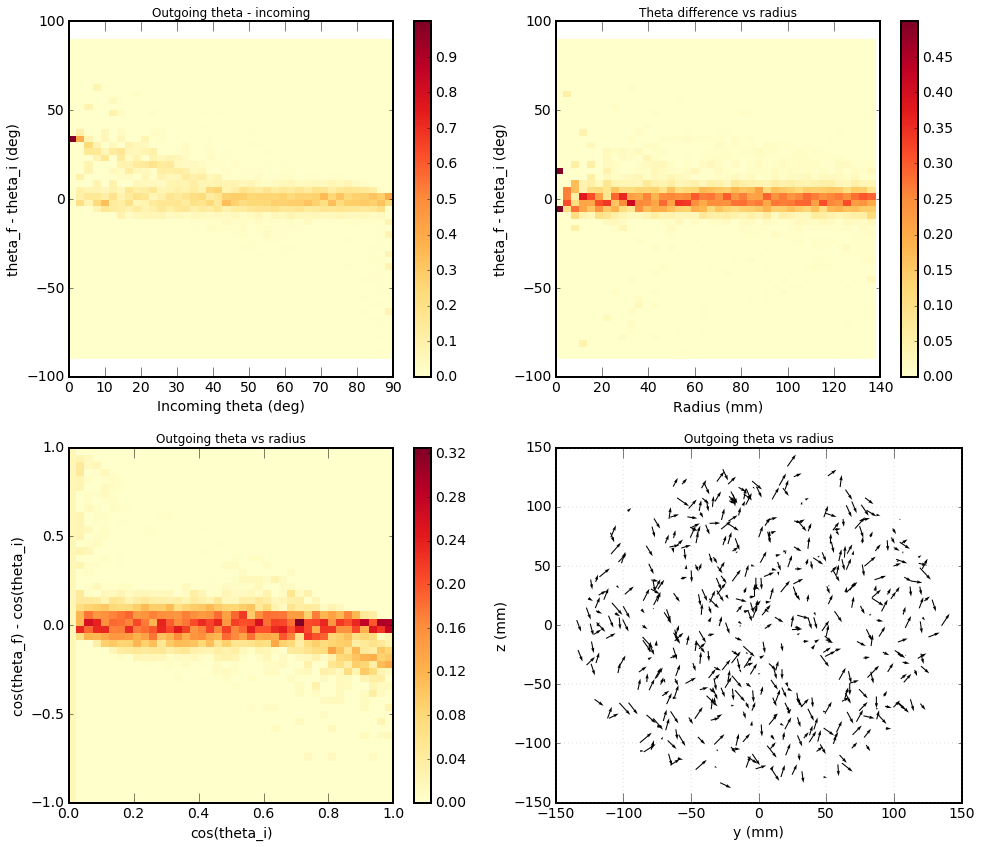

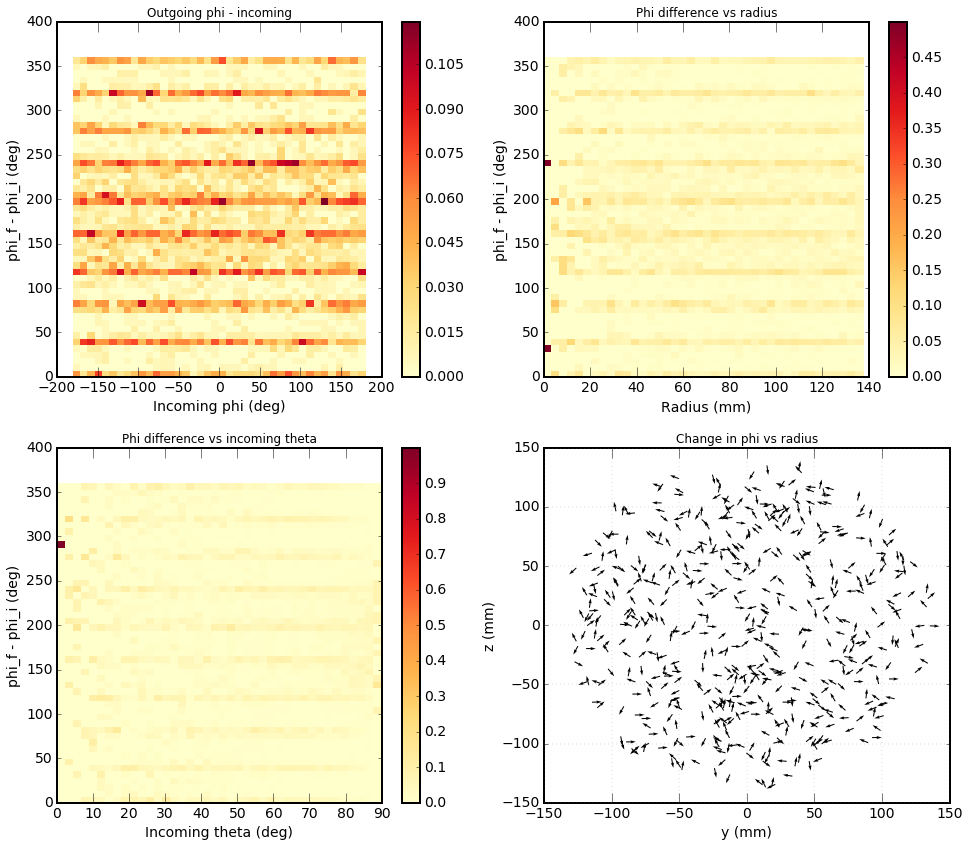

In [14]:
print 'Selecting all the events'
sel=( np.array([True]*len(data['y']))
     #*(data['z'] > 0)
     #*(data['r']>0)
    )
plotReflections(data,sel)


In [15]:
print np.sum(pmt_hits)

741


Selecting only the events that hit the PMT first


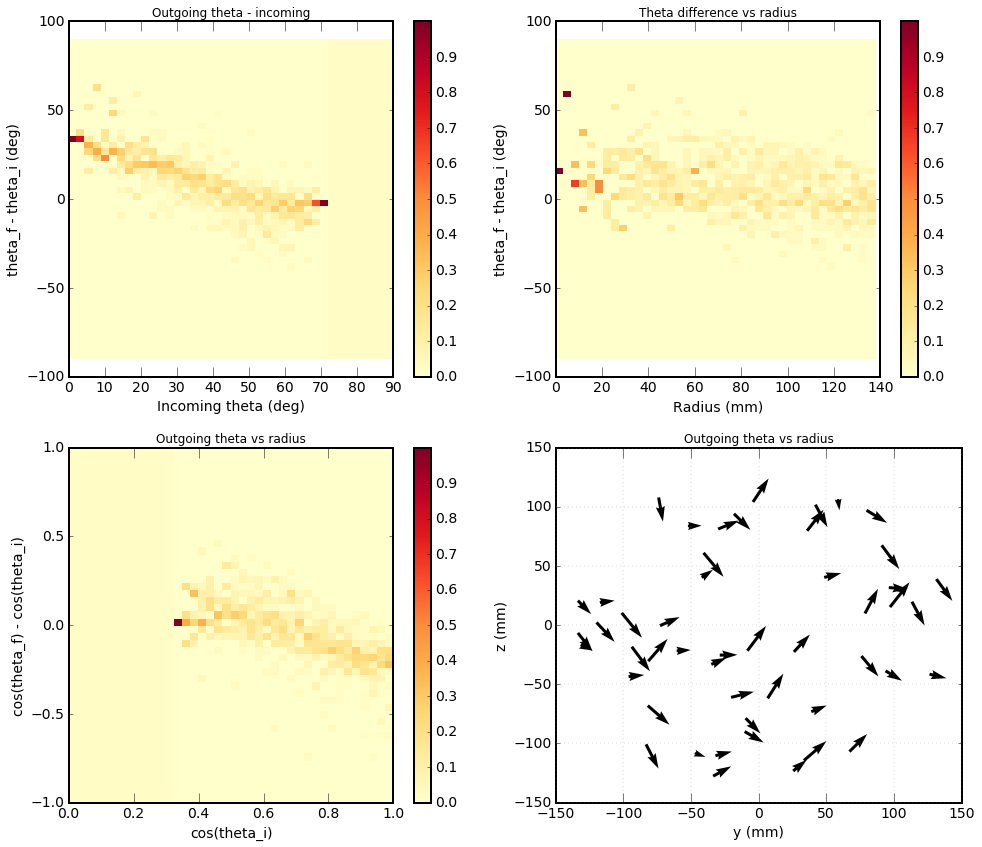

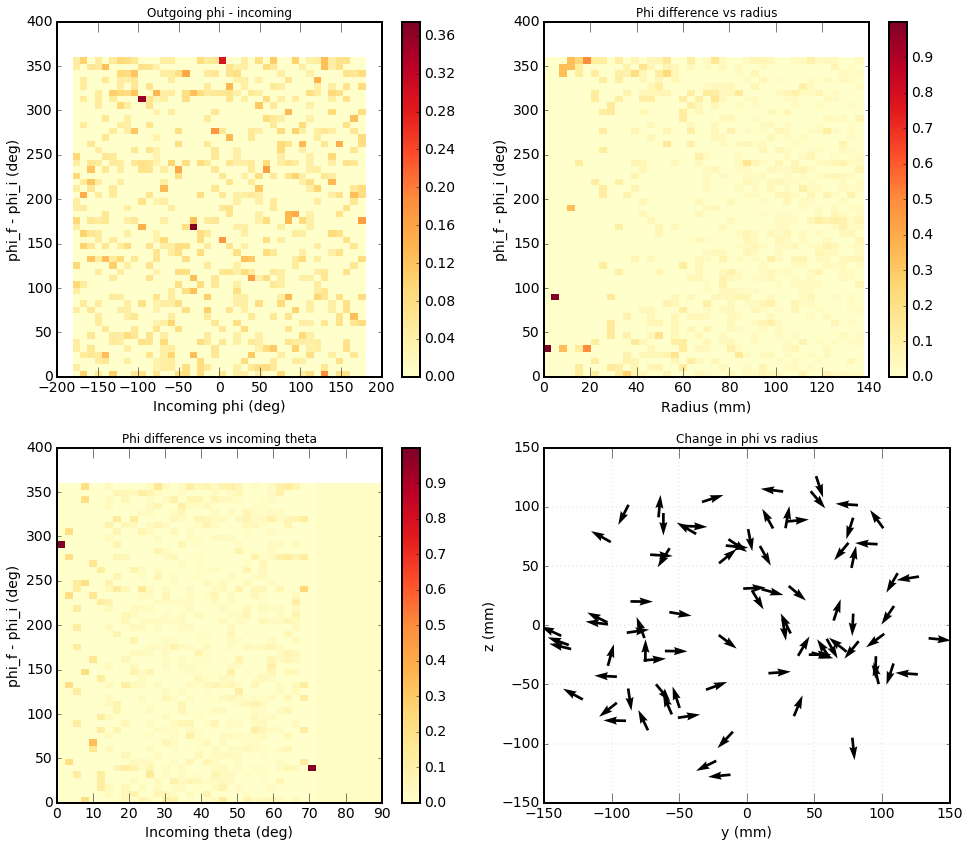

In [16]:
print 'Selecting only the events that hit the PMT first'
sel=( np.array([True]*len(data['y']))
     *pmt_hits
     #*(data['z'] > 0)
     #*(data['r']>0)
    )
plotReflections(data,sel)


Selecting the events that hit the petals first


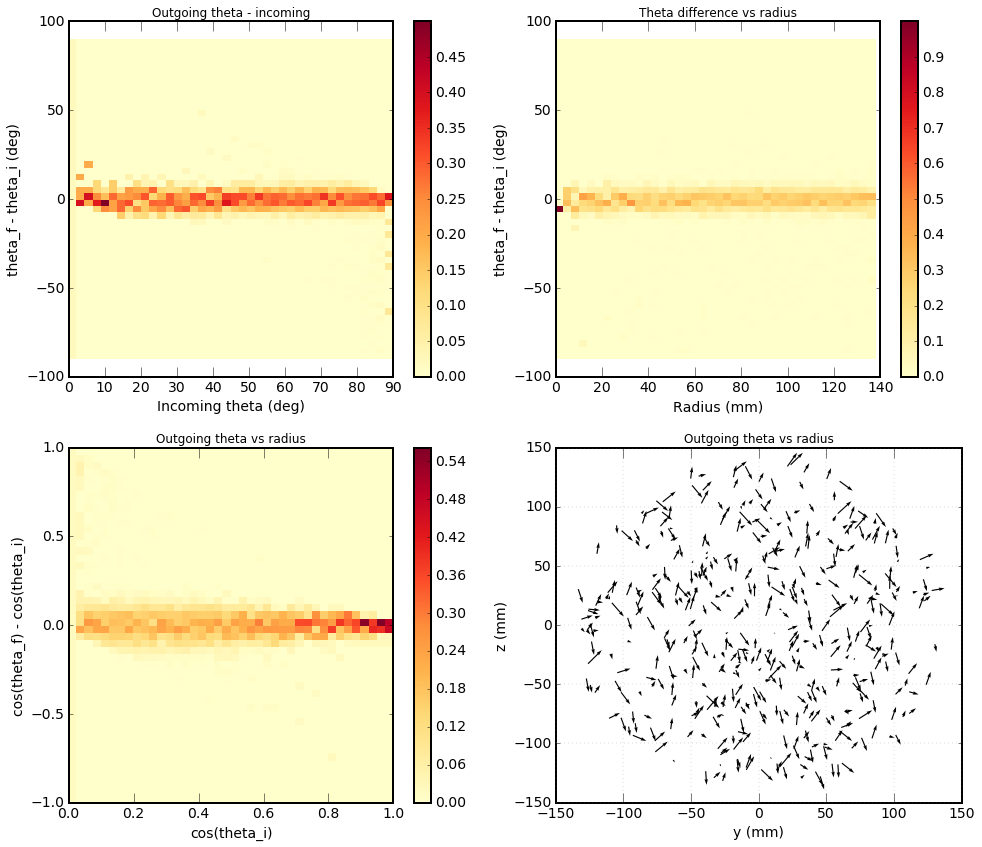

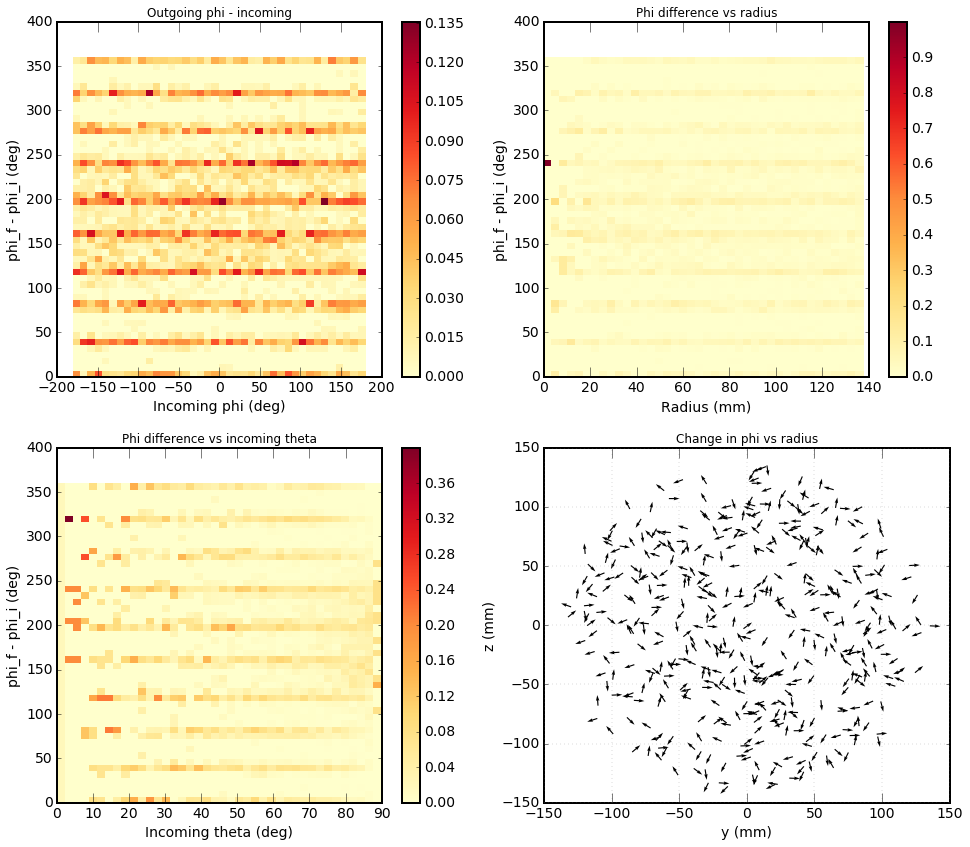

In [17]:
print 'Selecting the events that hit the petals first'
sel=( np.array([True]*len(data['y']))
     *conc_hits
     #*((np.rad2deg(data['phidiff'])%10) > 5.)
     #*(data['z'] > 0)
     #*(data['r']>0)
    )
plotReflections(data,sel)


In [615]:
condition = np.where((data['theta_f'][pmt_hits]-data['theta_i'][pmt_hits])<0.03)[0]
condition2 = np.where(data['theta_i'][pmt_hits] < np.deg2rad(15.))[0]
intersection =  np.intersect1d(condition, condition2)
#print len(condition)
#print condition
value = (data['theta_f'][pmt_hits]-data['theta_i'][pmt_hits])[intersection[0]]
ievent = np.where(np.abs((data['theta_f']-data['theta_i'])- value) <1E-7)[0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0